In [1]:
from WaveDataset import *
from pde import CartesianGrid, WavePDE, ScalarField, MemoryStorage, movie, FieldCollection, DataTracker
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
GENERATING = True
VERBOSE = True

In [34]:
class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, nx, speed, dt, t, interval, sampling_rate=1, verbose=False):
        self.num_samples = num_samples
        self.nx = nx
        self.speed = speed
        self.dt = dt
        self.t = t
        self.sampling_rate = sampling_rate
        self.verbose = verbose
        self.interval = interval
        self.generate_constraint()
        self.generate_epicenters()
        self.generate_final_states()

    def generate_constraint(self, constraint=None):
        if not constraint:
            self.constraint = np.full((self.nx, self.nx), self.speed)
            
            center = self.nx // 2
            side_length = self.nx // 2
        
            start_row, end_row = center - side_length // 2, center + side_length // 2 + 1
            start_col, end_col = center - side_length // 2, center + side_length // 2 + 1
        
            self.constraint[center - side_length // 2:1+center - side_length // 2, start_col:end_col] = 0
            self.constraint[center + side_length // 2:1+center + side_length // 2, start_col:end_col] = 0
            self.constraint[start_row:end_row, center - side_length // 2:1+center - side_length // 2] = 0
            self.constraint[start_row:end_row, center + side_length // 2:1+center + side_length // 2] = 0
            
            self.constraint[center:, center] = self.speed
        else:
            self.constraint = constraint
        
    def generate_epicenters(self):
        self.epicenters = torch.rand((self.num_samples, 2))

    def generate_final_states(self):
        self.initial_densities = []
        self.final_states = []
        for idx in range(self.num_samples):
            if not self.verbose:
                print("Generating sample", idx, "/", self.num_samples)
            grid = CartesianGrid([[0, 1], [0, 1]], [self.nx, self.nx], periodic=[True, True])
            self.initial_densities.append(ScalarField(grid))
            self.initial_densities[-1].insert([self.epicenters[idx][0], self.epicenters[idx][1]], 1)
            data_tracker = DataTracker(lambda x: x.data[0].copy(), interval=self.t/(self.interval*self.dt))
            trackers = [data_tracker]
            if self.verbose:
                trackers.append("progress")
            eq = WavePDE(self.constraint.T)
            initial_condition = eq.get_initial_condition(self.initial_densities[idx])
            eq.solve(initial_condition, t_range=self.t/self.dt, dt=self.dt, tracker=trackers, adaptive=True)
            self.final_states.append(data_tracker.data[1:])
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.epicenters[idx], self.initial_densities[idx].data[::int(1/self.sampling_rate), ::int(1/self.sampling_rate)], [i[::int(1/self.sampling_rate), ::int(1/self.sampling_rate)] for i in self.final_states[idx]]

In [51]:
NX = 128
SPEED = 0.003
DT = 0.01
T = 5
interval = 20
num_samples = 1
batch_size = 10
sampling_rate = 0.25

if GENERATING:
    dataset = WaveDataset(num_samples, NX, SPEED, DT, T, interval, sampling_rate=sampling_rate, verbose=VERBOSE)
    torch.save(dataset, './train_small.pt')
else:
    dataset = torch.load('./train_small.pt')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/500.0 [00:00<?, ?it/s]

In [52]:
center, inputs, outputs = dataset[0]

In [53]:
outputs[0].shape

(32, 32)

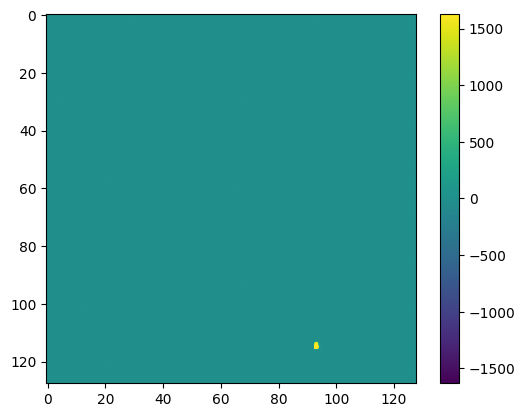

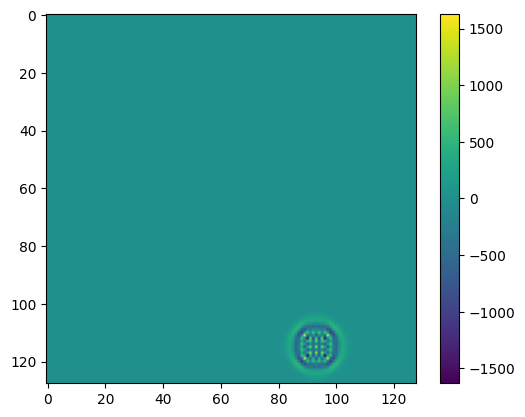

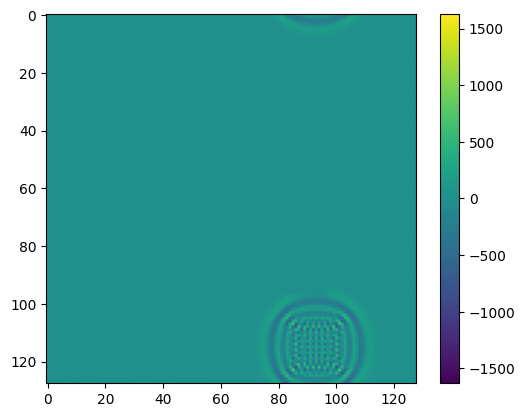

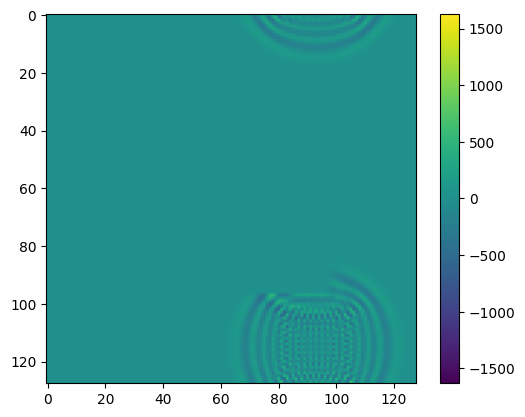

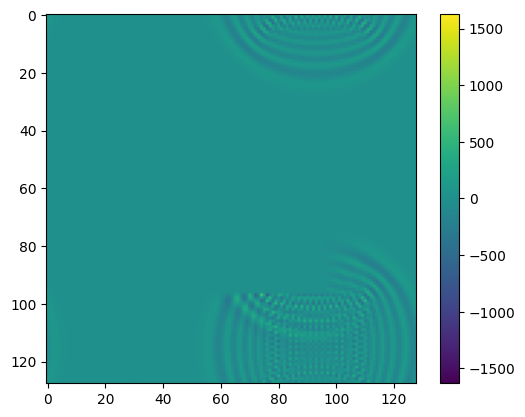

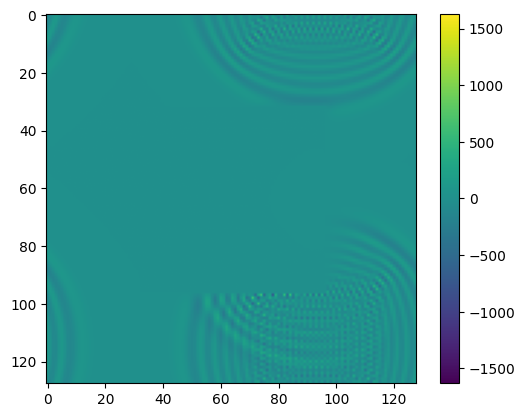

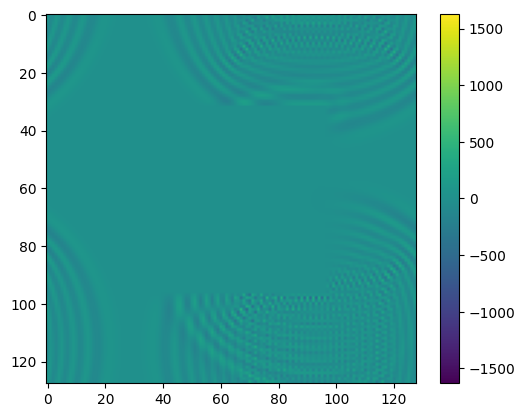

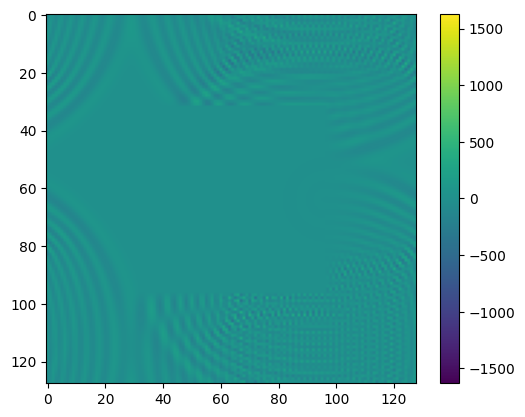

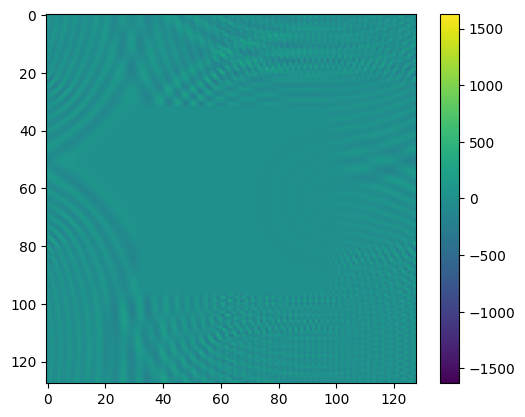

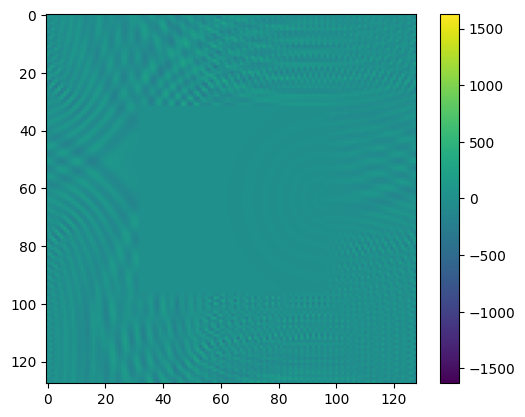

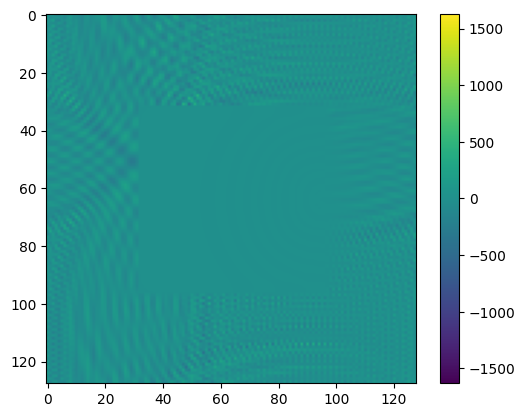

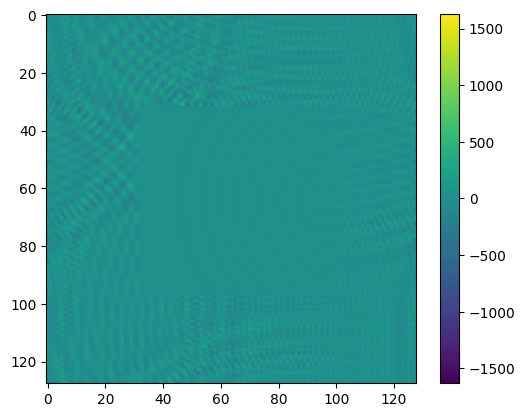

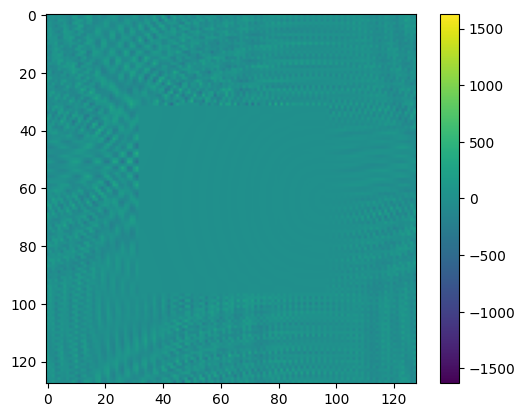

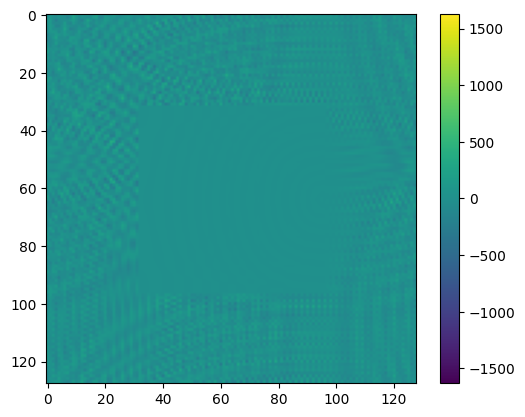

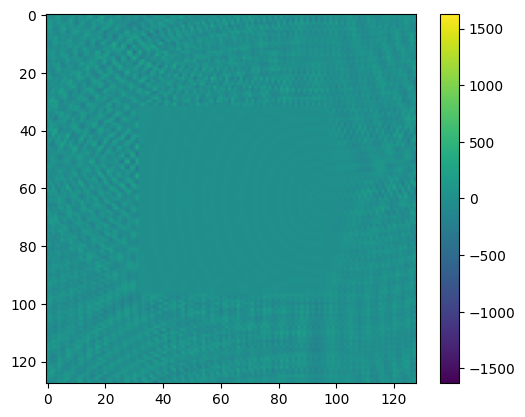

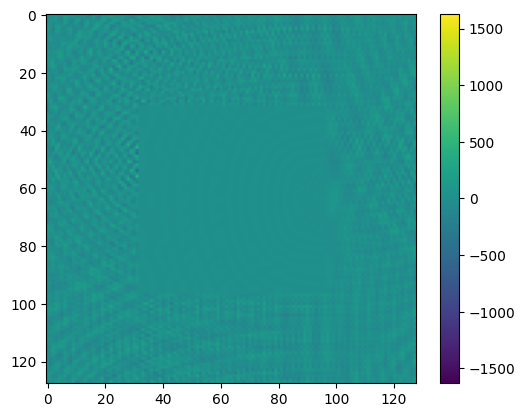

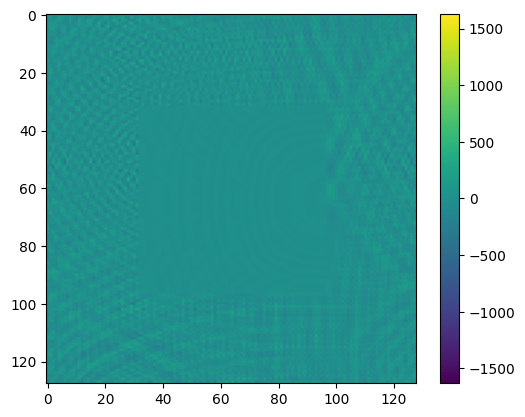

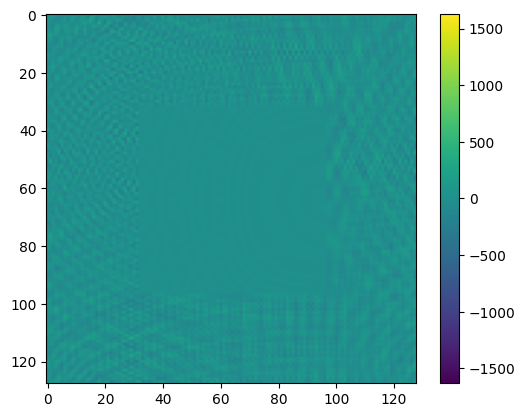

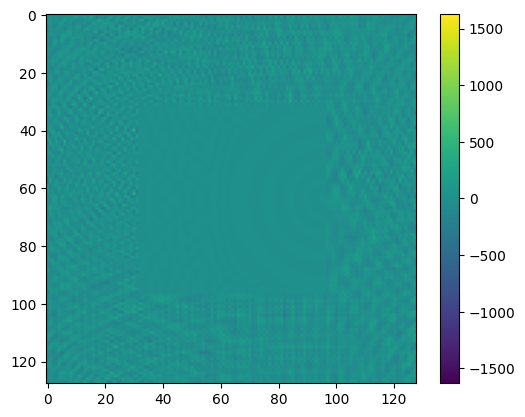

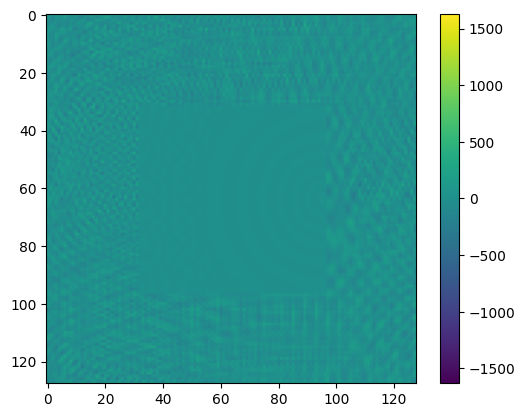

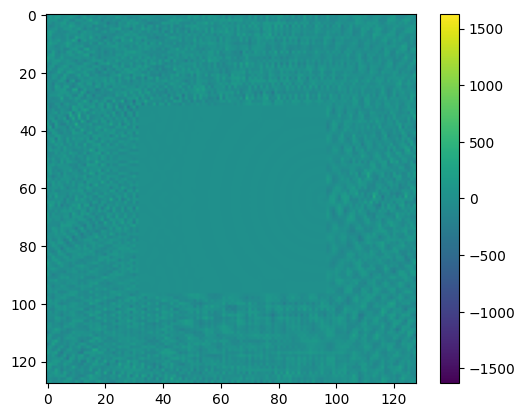

In [55]:
dataset.sampling_rate = 1
center, inputs, outputs = dataset[0]
plt.imshow(inputs, vmin=np.min(outputs), vmax=-np.min(outputs))
plt.colorbar()
plt.show()
for i in range(interval):
    plt.imshow(outputs[i], vmin=np.min(outputs), vmax=-np.min(outputs))
    plt.colorbar()
    plt.show()